In [88]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
color = sns.color_palette()

In [2]:
aisles = pd.read_csv('data/aisles.csv')
departments = pd.read_csv('data/departments.csv')
prior = pd.read_csv('data/order_products__prior.csv')
train = pd.read_csv('data/order_products__train.csv')
orders = pd.read_csv('data/orders.csv')
products = pd.read_csv('data/products.csv')


### Merging all the tables

In [17]:
all_orders = pd.concat([prior,train],axis = 0)
all_orders = all_orders.merge(products[['product_id','aisle_id','department_id']], how = 'inner', on = 'product_id')
all_orders = all_orders.merge(aisles, on = 'aisle_id')
all_orders = all_orders.merge(departments, on = 'department_id')
all_orders = all_orders.merge(orders[['order_id','user_id']], on = 'order_id')

In [19]:
all_orders

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,aisle,department,user_id
0,2,33120,1,1,86,16,eggs,dairy eggs,202279
1,2,28985,2,1,83,4,fresh vegetables,produce,202279
2,2,17794,6,1,83,4,fresh vegetables,produce,202279
3,2,43668,9,0,123,4,packaged vegetables fruits,produce,202279
4,2,9327,3,0,104,13,spices seasonings,pantry,202279
...,...,...,...,...,...,...,...,...,...
33819101,1015358,46477,1,0,6,2,other,other,27208
33819102,647259,36631,1,0,6,2,other,other,17880
33819103,2010951,16161,1,0,6,2,other,other,62266
33819104,2684414,1013,1,0,6,2,other,other,69235


### Preparing data for analysis

In [53]:
aisle_hist = all_orders[['user_id','add_to_cart_order','aisle']].groupby(['user_id','aisle']).sum().reset_index()
dept_hist = all_orders[['user_id','add_to_cart_order','department']].groupby(['user_id','department']).sum().reset_index()

In [54]:
# aisles and departments grouped by user id to calculate volume of 'add_to_cart_order' for each user id
user_volume = aisle_hist.groupby('user_id')['add_to_cart_order'].sum().reset_index()
user_volume = user_volume.rename(columns = {'add_to_cart_order':'volume'})

#adding a new column - volume
aisle_hist = aisle_hist.merge(user_volume, how = 'inner', on = 'user_id')
dept_hist = dept_hist.merge(user_volume, how = 'inner', on = 'user_id')

In [56]:
#aisle share and dept share
aisle_hist['aisle_share'] = aisle_hist['add_to_cart_order'] / aisle_hist['volume']
dept_hist['dept_share'] = dept_hist['add_to_cart_order'] / dept_hist['volume']

In [65]:
#Building a pivot table and filling NaN to 0.
aisle_vol_pivot = aisle_hist[['user_id','aisle','add_to_cart_order']].pivot(index = 'user_id', columns = 'aisle', values = 'add_to_cart_order').fillna(value = 0)
aisle_share_pivot = aisle_hist[['user_id','aisle','aisle_share']].pivot(index = 'user_id', columns = 'aisle', values = 'aisle_share').fillna(value = 0)

dept_vol_pivot = dept_hist[['user_id','department','add_to_cart_order']].pivot(index = 'user_id', columns = 'department', values = 'add_to_cart_order').fillna(value = 0)
dept_share_pivot = dept_hist[['user_id','department','dept_share']].pivot(index = 'user_id', columns = 'department', values = 'dept_share').fillna(value = 0)

In [68]:
aisle_vol_pivot

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
2,0.0,23.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,...,50.0,7.0,15.0,0.0,0.0,0.0,0.0,18.0,0.0,403.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0
5,5.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.0
206206,0.0,24.0,0.0,0.0,0.0,0.0,14.0,2.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,0.0
206207,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,...,16.0,44.0,0.0,25.0,14.0,0.0,0.0,65.0,0.0,103.0


In [70]:
aisle_share_pivot

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,...,0.017857,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.025000
2,0.00000,0.010628,0.000000,0.0,0.000000,0.0,0.004159,0.00000,0.0,0.0,...,0.023105,0.003235,0.006932,0.000000,0.00000,0.000000,0.0,0.008318,0.0,0.186229
3,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,...,0.038363,0.012788,0.000000,0.000000,0.00000,0.000000,0.0,0.028133,0.0,0.000000
4,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.060000,0.00000,0.000000,0.0,0.040000,0.0,0.000000
5,0.02008,0.076305,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.064257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0.00000,0.000000,0.009828,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.228501
206206,0.00000,0.021958,0.000000,0.0,0.000000,0.0,0.012809,0.00183,0.0,0.0,...,0.003660,0.000000,0.000000,0.000000,0.00000,0.003660,0.0,0.004575,0.0,0.000000
206207,0.00000,0.000000,0.000000,0.0,0.011862,0.0,0.000000,0.00000,0.0,0.0,...,0.008252,0.022692,0.000000,0.012893,0.00722,0.000000,0.0,0.033522,0.0,0.053120


In [66]:
dept_vol_pivot

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,35.0,26.0,0.0,0.0,76.0,0.0,0.0,...,14.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,30.0,94.0
2,0.0,0.0,28.0,75.0,21.0,0.0,88.0,453.0,199.0,0.0,...,0.0,23.0,12.0,0.0,0.0,88.0,24.0,0.0,346.0,311.0
3,0.0,0.0,0.0,16.0,0.0,0.0,0.0,62.0,11.0,15.0,...,5.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,177.0,57.0
4,2.0,0.0,4.0,6.0,0.0,0.0,1.0,0.0,5.0,0.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,8.0,49.0,1.0,2.0,...,5.0,19.0,0.0,0.0,0.0,8.0,0.0,0.0,142.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0.0,4.0,7.0,5.0,0.0,0.0,0.0,146.0,49.0,0.0,...,0.0,18.0,12.0,20.0,0.0,19.0,0.0,0.0,106.0,0.0
206206,0.0,0.0,3.0,94.0,3.0,0.0,55.0,104.0,18.0,2.0,...,39.0,24.0,18.0,0.0,3.0,88.0,36.0,0.0,285.0,134.0
206207,0.0,23.0,31.0,159.0,42.0,0.0,100.0,314.0,90.0,95.0,...,0.0,4.0,54.0,0.0,0.0,175.0,0.0,0.0,393.0,247.0


In [67]:
dept_share_pivot

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.00,0.000000,0.000000,0.125000,0.092857,0.0,0.000000,0.271429,0.000000,0.000000,...,0.050000,0.000000,0.000000,0.000000,0.000000,0.017857,0.000000,0.0,0.107143,0.335714
2,0.00,0.000000,0.012939,0.034658,0.009704,0.0,0.040665,0.209335,0.091959,0.000000,...,0.000000,0.010628,0.005545,0.000000,0.000000,0.040665,0.011091,0.0,0.159889,0.143715
3,0.00,0.000000,0.000000,0.040921,0.000000,0.0,0.000000,0.158568,0.028133,0.038363,...,0.012788,0.000000,0.000000,0.000000,0.000000,0.038363,0.000000,0.0,0.452685,0.145780
4,0.04,0.000000,0.080000,0.120000,0.000000,0.0,0.020000,0.000000,0.100000,0.000000,...,0.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.220000,0.020000
5,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.032129,0.196787,0.004016,0.008032,...,0.020080,0.076305,0.000000,0.000000,0.000000,0.032129,0.000000,0.0,0.570281,0.032129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0.00,0.009828,0.017199,0.012285,0.000000,0.0,0.000000,0.358722,0.120393,0.000000,...,0.000000,0.044226,0.029484,0.049140,0.000000,0.046683,0.000000,0.0,0.260442,0.000000
206206,0.00,0.000000,0.002745,0.086002,0.002745,0.0,0.050320,0.095151,0.016468,0.001830,...,0.035682,0.021958,0.016468,0.000000,0.002745,0.080512,0.032937,0.0,0.260750,0.122598
206207,0.00,0.011862,0.015988,0.082001,0.021661,0.0,0.051573,0.161939,0.046416,0.048994,...,0.000000,0.002063,0.027849,0.000000,0.000000,0.090253,0.000000,0.0,0.202682,0.127385


## Performing PCA analysis to reduce features

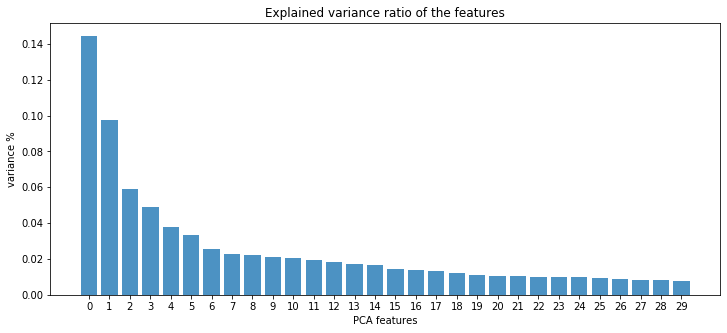

In [80]:
pca = PCA(n_components = 30)
pca_features = pca.fit_transform(aisle_share_pivot)

features = range(pca.n_components_)
plt.figure(figsize=(12,5))
#sns.barplot(features, pca.explained_variance_ratio_, alpha=0.8)
plt.bar(features, pca.explained_variance_ratio_, alpha = 0.8)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.title('Explained variance ratio of the features')

PCA_components = pd.DataFrame(pca_features)

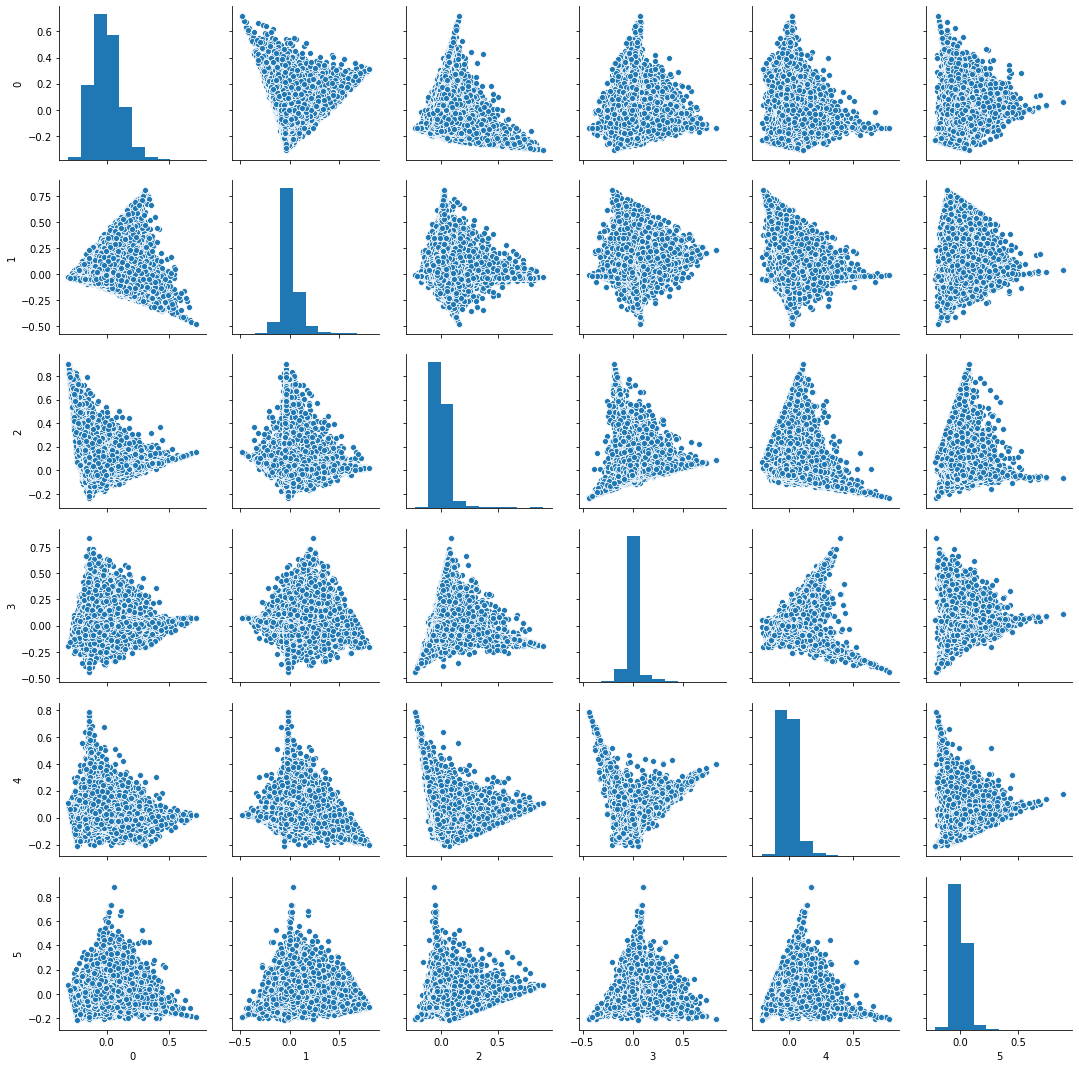

In [89]:
sns.pairplot(PCA_components[[0,1,2,3,4,5]])

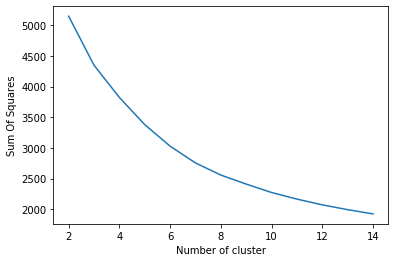

In [92]:
sum_of_squares = {}
labels = {}
for k in range(2,15):
    kmeans = KMeans(n_clusters = k).fit(PCA_components[[0,1,2,3,4,5]])
    sum_of_squares[k] = kmeans.inertia_
    labels[k] = kmeans.labels_
plt.figure()
plt.plot(list(sum_of_squares.keys()), list(sum_of_squares.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Sum Of Squares")
plt.show()

In [95]:
cluster_df = pd.concat([PCA_components[[0,1,2,3,4,5]],pd.Series(labels[6]).rename('cluster')], axis = 1)

/Users/jyothirmayeen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/jyothirmayeen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


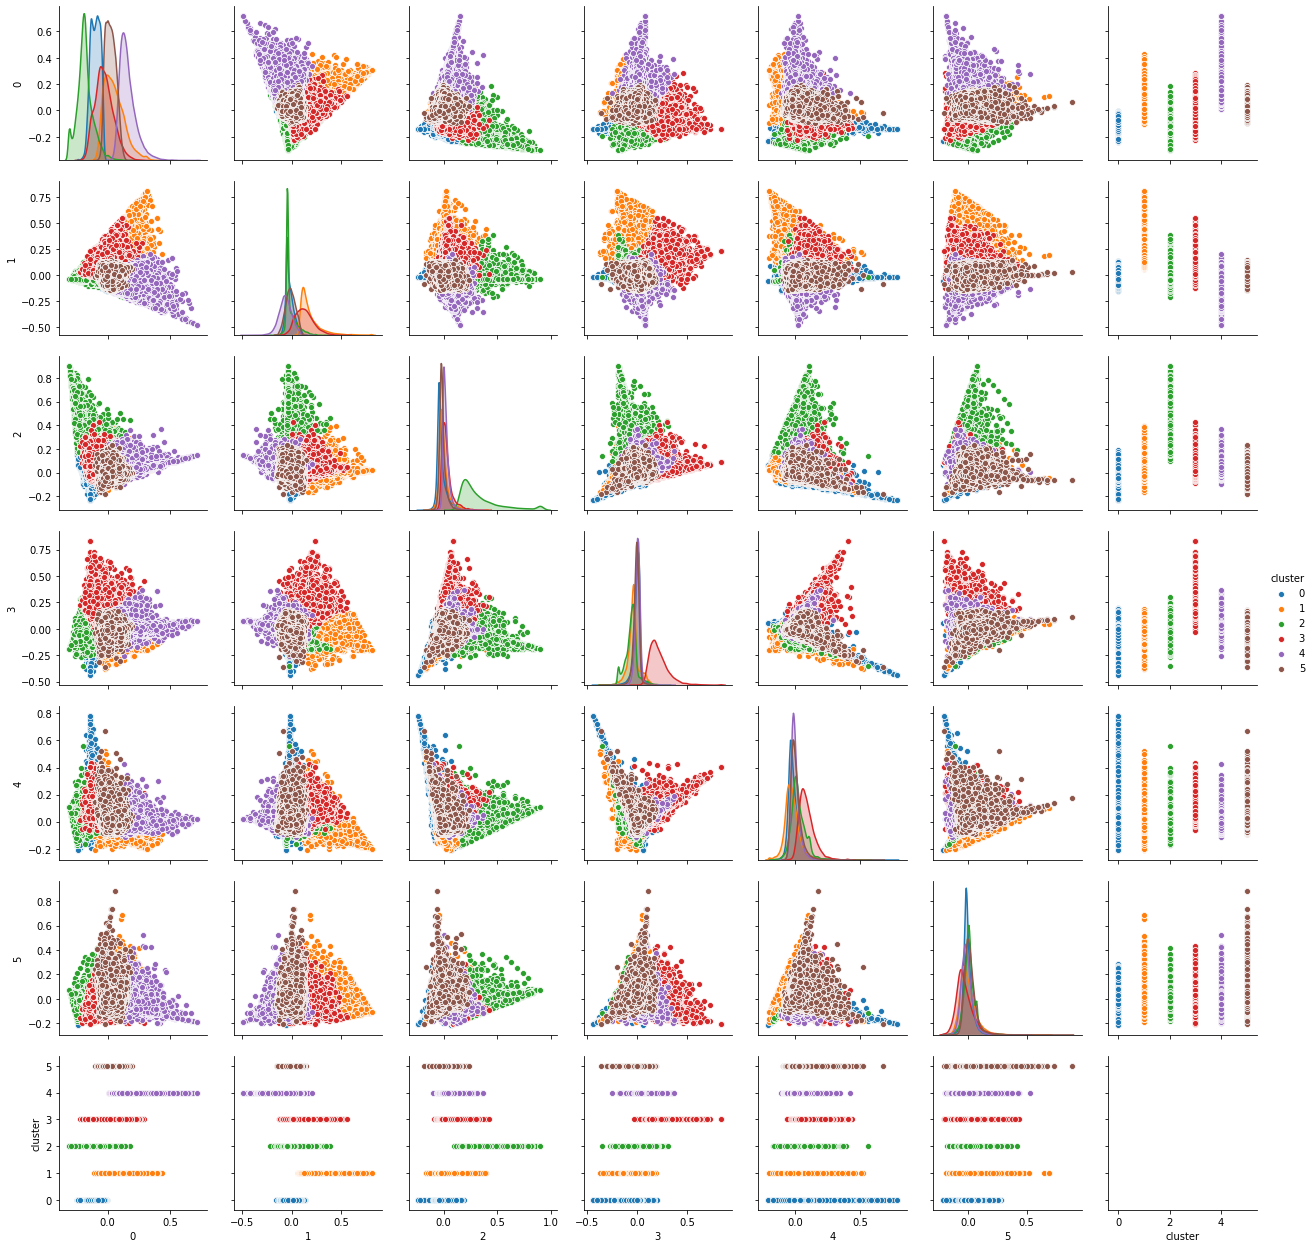

In [97]:
sns.pairplot(cluster_df, hue = 'cluster')

### Preparing data for cluster analysis

In [100]:
cluster_df = pd.concat([pd.Series(aisle_share_pivot.index),cluster_df],axis = 1)

In [101]:
cluster_df

,user_id,0,1,2,3,4,5,cluster
0,1,-0.103161,0.048616,-0.031831,-0.005636,-0.053020,-0.055276,0
1,2,-0.077766,0.077983,-0.076150,-0.101670,0.081779,-0.040407,0
2,3,0.057496,0.085719,0.001778,-0.013191,-0.028498,0.113073,5
3,4,-0.055343,0.134731,-0.002395,-0.037706,-0.087810,-0.027370,1
4,5,0.133936,-0.019591,-0.020958,-0.003729,0.057736,0.138887,5
...,...,...,...,...,...,...,...,...
206204,206205,-0.021674,0.081783,-0.073481,-0.088438,0.155967,-0.022707,5
206205,206206,-0.040316,-0.036658,-0.024048,0.010063,-0.051003,0.000825,0
206206,206207,-0.022110,-0.032613,-0.009468,-0.015799,0.021502,0.020458,5
206207,206208,-0.002217,-0.010633,-0.037620,-0.007752,0.028741,0.044839,5


In [126]:
aisle_hist

,user_id,aisle,add_to_cart_order,volume,aisle_share,cluster
0,1,candy chocolate,8,280,0.028571,0
1,1,cereal,26,280,0.092857,0
2,1,cream,17,280,0.060714,0
3,1,fresh fruits,30,280,0.107143,0
4,1,milk,9,280,0.032143,0
...,...,...,...,...,...,...
5919835,206209,soft drinks,26,912,0.028509,0
5919836,206209,soy lactosefree,20,912,0.021930,0
5919837,206209,spices seasonings,9,912,0.009868,0
5919838,206209,trash bags liners,6,912,0.006579,0


In [115]:
aisle_hist = aisle_hist.merge(cluster_df[['user_id','cluster']], on = 'user_id')

In [150]:
dept_hist = dept_hist.merge(cluster_df[['user_id','cluster']], on = 'user_id')

In [128]:
#cluster wise aisle share

cluster_aisle_share = pd.DataFrame(columns = ['aisle','add_to_cart_order','aisle_share','cluster'])
for i in range(0,6):
    x = aisle_hist[aisle_hist['cluster'] == i]
    x = x.groupby('aisle')['add_to_cart_order'].sum().reset_index()
    x['aisle_share'] = x['add_to_cart_order']
    x['aisle_share'] = x['aisle_share'].apply(lambda f: f / x['add_to_cart_order'].sum())
    x['cluster'] = i
    cluster_aisle_share = pd.concat([x,cluster_aisle_br], axis = 0)


In [129]:
cluster_aisle_share


,aisle,add_to_cart_order,aisle_share,cluster
0,air fresheners candles,52357,0.000374,5
1,asian foods,875071,0.006248,5
2,baby accessories,45110,0.000322,5
3,baby bath body care,48470,0.000346,5
4,baby food formula,2598670,0.018556,5
...,...,...,...,...
129,trash bags liners,155469,0.001843,0
130,vitamins supplements,128459,0.001523,0
131,water seltzer sparkling water,2041763,0.024209,0
132,white wines,118712,0.001408,0


In [146]:
t20 = list(aisle_hist.groupby('aisle')['add_to_cart_order'].sum().sort_values(ascending = False)[0:20].index)
t20

['fresh vegetables',
 'fresh fruits',
 'packaged vegetables fruits',
 'yogurt',
 'packaged cheese',
 'chips pretzels',
 'water seltzer sparkling water',
 'milk',
 'frozen produce',
 'bread',
 'energy granola bars',
 'crackers',
 'soy lactosefree',
 'ice cream ice',
 'refrigerated',
 'baby food formula',
 'frozen meals',
 'fresh herbs',
 'lunch meat',
 'soup broth bouillon']

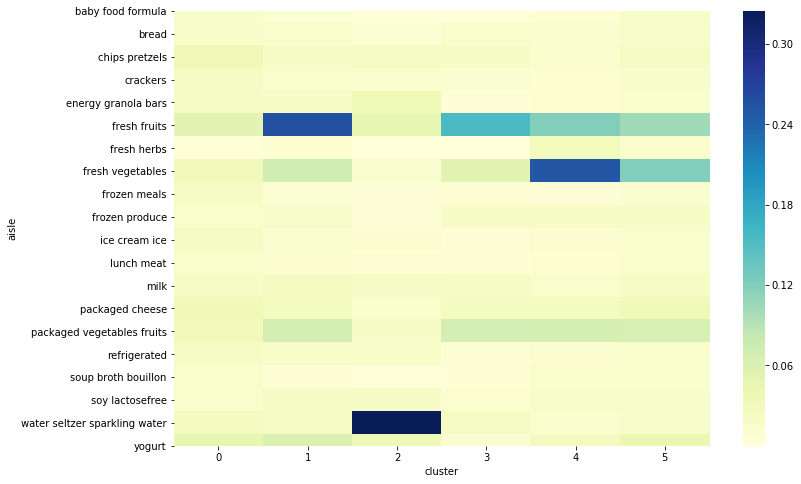

In [141]:
aisle_heat = cluster_aisle_br[cluster_aisle_br['aisle'].isin(t20)]
aisle_heat = aisle_heat.pivot(index = 'aisle', columns = 'cluster', values = 'aisle_share')
plt.figure(figsize=(12,8))
sns.heatmap(aisle_heat,cmap="YlGnBu")

plt.show()

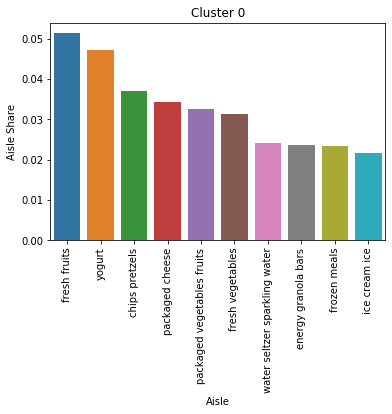

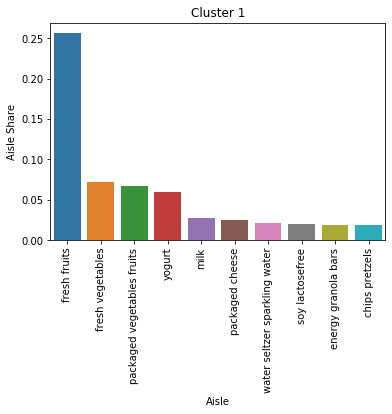

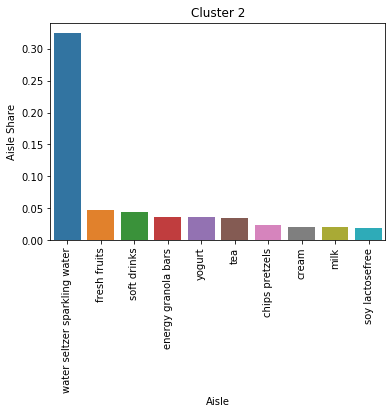

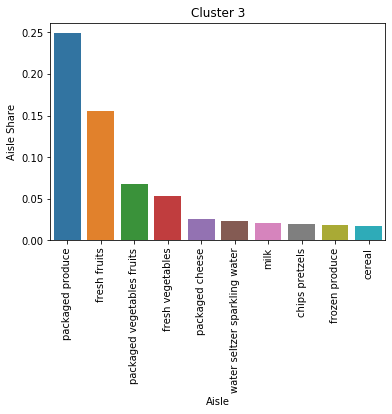

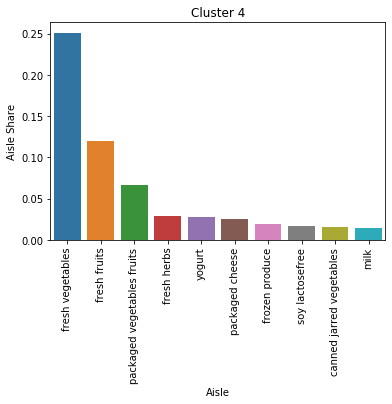

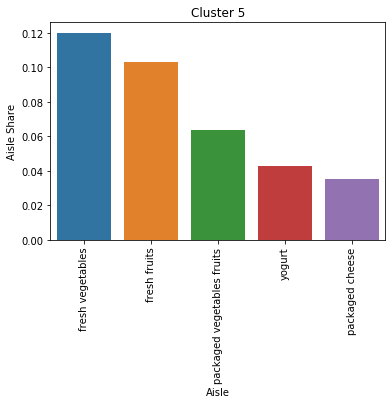

In [147]:
for i in range(0,6):
    data = cluster_aisle_share[cluster_aisle_share['cluster'] == i].sort_values('aisle_share', ascending = False)[0:10]
    x = sns.barplot(data = data, x = 'aisle', y = 'aisle_share')
    x.set_xticklabels(x.get_xticklabels(), rotation=90)
    plt.title('Cluster ' + str(i))
    x.set(xlabel = 'Aisle', ylabel = 'Aisle Share')
    plt.show()

In [151]:
cluster_dept_share = pd.DataFrame(columns = ['department','add_to_cart_order','dept_share','cluster'])
for i in range(0,6):
    x = dept_hist[dept_hist['cluster'] == i]
    x = x.groupby('department')['add_to_cart_order'].sum().reset_index()
    x['dept_share'] = x['add_to_cart_order']
    x['dept_share'] = x['dept_share'].apply(lambda f: f / x['add_to_cart_order'].sum())
    x['cluster'] = i
    cluster_dept_share = pd.concat([x,cluster_dept_share], axis = 0)

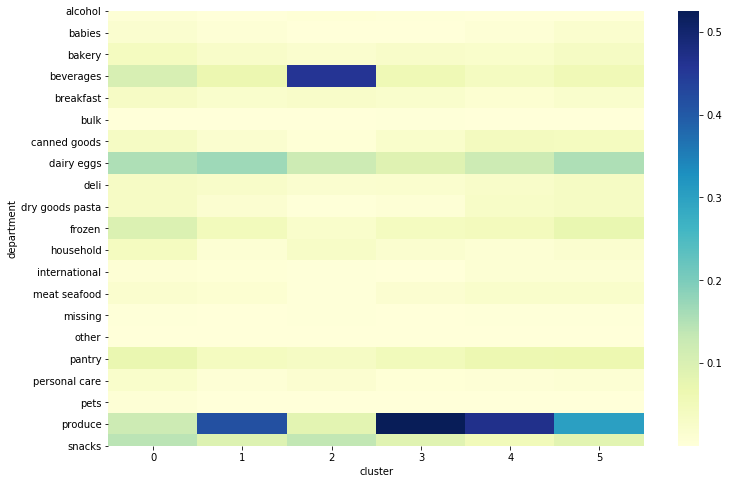

In [158]:
dept_heat = cluster_dept_share.pivot(index = 'department', columns = 'cluster', values = 'dept_share')
plt.figure(figsize=(12,8))
sns.heatmap(dept_heat,cmap="YlGnBu")

plt.show()

In [159]:
cluster_dept_share

,department,add_to_cart_order,dept_share,cluster
0,alcohol,210345,0.001502,5
1,babies,2773124,0.019802,5
2,bakery,4940247,0.035276,5
3,beverages,7816106,0.055811,5
4,breakfast,2981603,0.021290,5
...,...,...,...,...
16,pantry,5903976,0.070003,0
17,personal care,1960434,0.023245,0
18,pets,524406,0.006218,0
19,produce,10310195,0.122248,0


In [160]:
cluster_df['cluster'].value_counts().sort_index()

0    73681
1    15136
2     3850
3     7948
4    32842
5    72752
Name: cluster, dtype: int64

In [164]:
all_orders = all_orders.merge(cluster_df[['user_id','cluster']], on = 'user_id')

In [165]:
all_orders

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,aisle,department,user_id,cluster
0,2,33120,1,1,86,16,eggs,dairy eggs,202279,5
1,2,28985,2,1,83,4,fresh vegetables,produce,202279,5
2,2,17794,6,1,83,4,fresh vegetables,produce,202279,5
3,2,43668,9,0,123,4,packaged vegetables fruits,produce,202279,5
4,2,9327,3,0,104,13,spices seasonings,pantry,202279,5
...,...,...,...,...,...,...,...,...,...,...
33819101,2942910,36885,1,1,134,5,specialty wines champagnes,alcohol,95228,0
33819102,77392,47713,1,1,134,5,specialty wines champagnes,alcohol,95228,0
33819103,679020,47713,1,1,134,5,specialty wines champagnes,alcohol,95228,0
33819104,1264096,47713,1,1,134,5,specialty wines champagnes,alcohol,95228,0


In [170]:
cluster_df.to_csv('data/interim/cluster_df.csv')

In [169]:
all_orders.to_csv('data/interim/all_orders.csv')